In [22]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import keras
from keras.preprocessing import image
from keras.models import Sequential
from keras.layers import Conv2D, MaxPool2D, Flatten, Dense, Dropout, BatchNormalization
from tensorflow.keras.preprocessing.image import ImageDataGenerator
import cv2
from tensorflow.keras.applications import VGG16, InceptionResNetV2
from keras import regularizers
from tensorflow.keras.optimizers import Adam, RMSprop, SGD, Adamax
import tensorflow as tf
import os

In [3]:
train_dir = "/kaggle/input/fer2013/train" #passing the path with training images
test_dir = "/kaggle/input/fer2013/test"   #passing the path with testing images

In [4]:
img_size = 48 #original size of the image

In [5]:
train_datagen = ImageDataGenerator(#rotation_range = 180,
                                         width_shift_range = 0.1,
                                         height_shift_range = 0.1,
                                         horizontal_flip = True,
                                         rescale = 1./255,
                                         #zoom_range = 0.2,
                                         validation_split = 0.2
                                        )
validation_datagen = ImageDataGenerator(rescale = 1./255,
                                         validation_split = 0.2)

In [6]:
train_generator = train_datagen.flow_from_directory(directory = train_dir,
                                                    target_size = (img_size,img_size),
                                                    batch_size = 64,
                                                    color_mode = "grayscale",
                                                    class_mode = "categorical",
                                                    subset = "training"
                                                   )
validation_generator = validation_datagen.flow_from_directory( directory = test_dir,
                                                              target_size = (img_size,img_size),
                                                              batch_size = 64,
                                                              color_mode = "grayscale",
                                                              class_mode = "categorical",
                                                              subset = "validation"
                                                             )

Found 22968 images belonging to 7 classes.
Found 1432 images belonging to 7 classes.


In [7]:
model = tf.keras.models.Sequential([
    Conv2D(32, kernel_size=(3, 3), padding='same', activation='relu', input_shape=(48, 48, 1)),
    Conv2D(64, (3, 3), padding='same', activation='relu'),
    MaxPooling2D(pool_size=(2, 2)),
    BatchNormalization(),
    Dropout(0.25),
    
    Conv2D(128, (3, 3), padding='same', activation='relu'),
    MaxPooling2D(pool_size=(2, 2)),
    BatchNormalization(),
    Dropout(0.25),
    
    Conv2D(256, (3, 3), padding='same', activation='relu'),
    MaxPooling2D(pool_size=(2, 2)),
    BatchNormalization(),
    Dropout(0.25),
    
    Flatten(),
    Dense(512, activation='relu'),
    BatchNormalization(),
    Dropout(0.5),
    Dense(7, activation='softmax')
])

In [8]:
# Compile the model
model.compile(optimizer=Adam(lr=0.0001),
              loss='categorical_crossentropy',
              metrics=['accuracy'])

In [9]:
# Define callbacks
early_stopping = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)

In [10]:
# Train the model with modified parameters
history = model.fit(train_generator,
                    epochs=60,
                    validation_data=validation_generator,
                    callbacks=[early_stopping])

Epoch 1/60
359/359 [==============================] - 295s 818ms/step - loss: 2.8614 - accuracy: 0.1987 - val_loss: 2.0247 - val_accuracy: 0.2004
Epoch 2/60
359/359 [==============================] - 287s 800ms/step - loss: 2.3737 - accuracy: 0.2405 - val_loss: 1.8237 - val_accuracy: 0.3017
Epoch 3/60
359/359 [==============================] - 280s 779ms/step - loss: 2.1713 - accuracy: 0.2759 - val_loss: 1.7824 - val_accuracy: 0.3415
Epoch 4/60
359/359 [==============================] - 285s 792ms/step - loss: 2.0620 - accuracy: 0.3046 - val_loss: 1.6206 - val_accuracy: 0.3715
Epoch 5/60
359/359 [==============================] - 283s 788ms/step - loss: 1.9551 - accuracy: 0.3299 - val_loss: 1.7154 - val_accuracy: 0.3708
Epoch 6/60
359/359 [==============================] - 284s 790ms/step - loss: 1.8444 - accuracy: 0.3623 - val_loss: 1.5391 - val_accuracy: 0.4260
Epoch 7/60
359/359 [==============================] - 284s 790ms/step - loss: 1.7693 - accuracy: 0.3780 - val_loss: 1.4631 -

In [14]:
# Save the model
model.save('model_optimal.h5')

In [13]:
# Convert the model to TensorFlow Lite format
converter = tf.lite.TFLiteConverter.from_keras_model(model)
tflite_model = converter.convert()

# Save the TensorFlow Lite model to a file
with open('model_optimal.tflite', 'wb') as f:
    f.write(tflite_model)

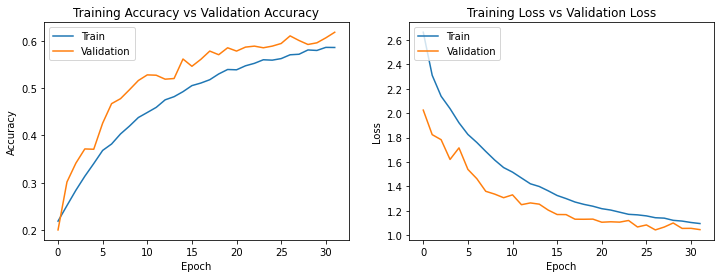

In [15]:
fig , ax = plt.subplots(1,2)
train_acc = history.history['accuracy']
train_loss = history.history['loss']
fig.set_size_inches(12,4)

ax[0].plot(history.history['accuracy'])
ax[0].plot(history.history['val_accuracy'])
ax[0].set_title('Training Accuracy vs Validation Accuracy')
ax[0].set_ylabel('Accuracy')
ax[0].set_xlabel('Epoch')
ax[0].legend(['Train', 'Validation'], loc='upper left')

ax[1].plot(history.history['loss'])
ax[1].plot(history.history['val_loss'])
ax[1].set_title('Training Loss vs Validation Loss')
ax[1].set_ylabel('Loss')
ax[1].set_xlabel('Epoch')
ax[1].legend(['Train', 'Validation'], loc='upper left')

plt.show()

(48, 48)


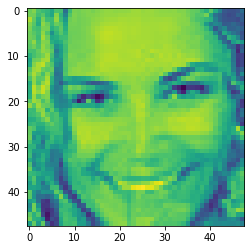

In [16]:
img = image.load_img("/kaggle/input/fer2013/test/happy/PrivateTest_10077120.jpg",target_size = (48,48),color_mode = "grayscale")
img = np.array(img)
plt.imshow(img)
print(img.shape) #prints (48,48) that is the shape of our image

In [20]:
train_loss, train_acc = model.evaluate(train_generator)
test_loss, test_acc   = model.evaluate(validation_generator)
print("final train accuracy = {:.2f} , validation accuracy = {:.2f}".format(train_acc*100, test_acc*100))

23/23 [==============================] - 4s 182ms/step - loss: 1.0436 - accuracy: 0.6103
final train accuracy = 61.60 , validation accuracy = 61.03


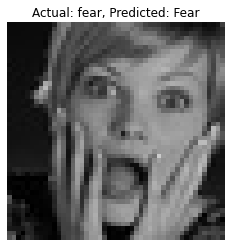

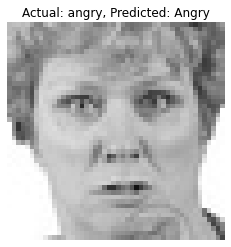

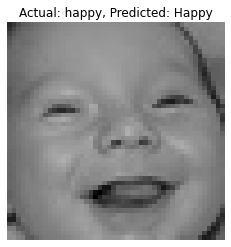

In [62]:
# Function to predict emotion for an image
def predict_emotion(image_path, model):
    img = image.load_img(image_path, target_size=(48, 48), color_mode='grayscale')
    img = image.img_to_array(img)
    img = np.expand_dims(img, axis=0)
    result = model.predict(img)
    return np.argmax(result)

# Function to display image with emotions
def display_image_with_emotions(image_path, actual_emotion, predicted_emotion, label_dict):
    img = cv2.imread(image_path)
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    plt.imshow(img)
    plt.title(f"Actual: {actual_emotion}, Predicted: {label_dict[predicted_emotion]}")
    plt.axis('off')
    plt.show()

# Function to predict and display random images
def predict_and_display_random_images(dataset_dir, num_images, model):
    label_dict = {0: 'Angry', 1: 'Disgust', 2: 'Fear', 3: 'Happy', 4: 'Neutral', 5: 'Sad', 6: 'Surprise'}

    all_image_paths = []
    for root, dirs, files in os.walk(dataset_dir):
        for file in files:
            if file.endswith('.jpg'):
                all_image_paths.append(os.path.join(root, file))

    random_indices = np.random.choice(len(all_image_paths), num_images, replace=False)

    for i in random_indices:
        image_path = all_image_paths[i]

        # Extract actual emotion from the directory name
        actual_emotion = os.path.basename(os.path.dirname(image_path))

        predicted_emotion = predict_emotion(image_path, model)

        # Display the image, actual emotion, and predicted emotion
        display_image_with_emotions(image_path, actual_emotion, predicted_emotion, label_dict)

# Example usage:
dataset_dir = "/kaggle/input/fer2013/test"  # Change this to your dataset directory
num_images = 3  # Number of random images to predict and display
predict_and_display_random_images(dataset_dir, num_images, model)